In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import json, requests, time
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sqlalchemy import create_engine

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, mean_squared_error

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')

# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [ ]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [ ]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        df = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~df["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        
        time.sleep(15)


We can use the `<=>` operator to run vector search within the database

In [ ]:
vec = json.loads(df.embedding[1]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    "bundleId"
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df__ = pd.read_sql(sql_query, con=db_con)

df__

# What you need to do
## The hypothesis
We assume that apps with similar desciptions, would have a similar asking price in the auctions (`sentPrice` column).

Use cosine similarity (`<=>`) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

## Is it consistent?
There are several other features in the auctions table (such as `CountryCode` and `OS`), 
Do your findings hold for those as well?

In [ ]:
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn

In [ ]:
# TODO: Please write your analysis here

In [2]:
## func section 
def get_auctions_data_from_sql(engine, sql_query = 'SELECT * FROM auctions;'):
    
    with engine.connect() as db_con:
        auction_df = pd.read_sql(sql_query, con=db_con)
        
    return auction_df

def get_app_vectors_data_from_sql(engine, sql_query = 'SELECT * FROM app_vectors;'):
    
    has_embedding = False
    while not has_embedding:
        with engine.connect() as db_con:
            app_vectors_df = pd.read_sql(sql_query, con=db_con)
        has_embedding = (~app_vectors_df["embedding"].isna()).all()
        
        if not has_embedding:
            print("Waiting for embeddings...")
            time.sleep(15)
            
    return app_vectors_df

def plot_sorted_by_price_distribution(auction_df, first_column, second_column, first_word = "iOS", second_word = "Android", ios_step=10, and_step=10):
    # Function to adjust ticks
    def adjust_ticks(labels, step):
        return [label for index, label in enumerate(labels) if index % step == 0], [index for index in range(len(labels)) if index % step == 0]

    # Calculate value counts and sort them for both OS versions
    ios_value_counts_sorted = auction_df[auction_df[first_column].str.contains(first_word, na=False)][second_column].value_counts().sort_index(ascending=True)
    and_value_counts_sorted = auction_df[auction_df[first_column].str.contains(second_word, na=False)][second_column].value_counts().sort_index(ascending=True)

    # Determine steps for tick intervals
    ios_step = max(1, len(ios_value_counts_sorted) // ios_step)
    and_step = max(1, len(and_value_counts_sorted) // and_step)

    # Recalculate tick positions and labels
    ios_thin_labels, ios_thin_ticks = adjust_ticks(ios_value_counts_sorted.index.tolist(), ios_step)
    and_thin_labels, and_thin_ticks = adjust_ticks(and_value_counts_sorted.index.tolist(), and_step)

    # Increase figure size for better clarity
    plt.figure(figsize=(10, 8))

    # iOS Plot adjustments
    plt.subplot(2, 1, 1)
    sns.barplot(x=ios_value_counts_sorted.index, y=ios_value_counts_sorted.values)
    plt.title(f'{first_word} {second_column} Distribution')
    plt.xlabel(second_column)
    plt.ylabel('Frequency')
    plt.xticks(ticks=ios_thin_ticks, labels=ios_thin_labels, rotation=45)

    # Android Plot adjustments
    plt.subplot(2, 1, 2)
    sns.barplot(x=and_value_counts_sorted.index, y=and_value_counts_sorted.values)
    plt.title(f'{second_word} {second_column} Distribution')
    plt.xlabel(second_column)
    plt.ylabel('Frequency')
    plt.xticks(ticks=and_thin_ticks, labels=and_thin_labels, rotation=45)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Assuming we have some function to get vectors (embeddings) for bundle IDs
def get_embedding(bundle_id):
    return bundle_id_to_embedding.get(bundle_id, None)
    
# Function to get similar apps based on Mahalanobis distance
def find_similar_apps_mahalanobis(bundle_id, top_n=10):
    
    # Define Mahalanobis distance function
    def mahalanobis_distance(vec1, vec2, inv_cov_matrix):
        delta = vec1 - vec2
        m_distance = np.dot(np.dot(delta, inv_cov_matrix), delta)
        return np.sqrt(max(m_distance, 0))  # Prevent negative values under the square root

    target_vec = get_embedding(bundle_id)
    if target_vec is not None:
        distances = []
        for other_id, other_vec in bundle_id_to_embedding.items():
            if other_id != bundle_id:
                dist = mahalanobis_distance(np.array(target_vec), np.array(other_vec), inverse_covariance_matrix)
                distances.append((other_id, dist))
        # Sort by distance, return closest apps
        distances.sort(key=lambda x: x[1])
        return [bundle_id for bundle_id, dist in distances[:top_n]]
    else:
        return []

def find_similar_apps_cosine(bundle_id, top_n=10):
    # Check if the bundle_id is in the app_similarity dictionary
    if bundle_id in app_similarity and 'cosine' in app_similarity[bundle_id]:
        # Fetch the list of similar apps based on cosine similarity
        similar_apps = app_similarity[bundle_id]['cosine']
        # Return the top N similar apps, or all if there are fewer than N
        return similar_apps[:top_n]
    else:
        # Return an empty list if no similarities are found or the app isn't in the dictionary
        return []

# Function to calculate average price for a list of apps
def calculate_average_price(similar_apps, auction_data):
    
    prices = auction_data[auction_data['bundleId'].isin(similar_apps)]['sentPrice']
    return prices.mean() if not prices.empty else None
   
def get_fallback_prices(new_row, auction_df):
    fallbacks = [
        ('unitDisplayType', 'countryCode'),  # First level fallback
        ('brandName', 'countryCode'),       # Second level fallback
        ('bundleId', 'countryCode'),
        ('bundleId',), # Third level fallback
        ()                                  # Final fallback to overall average
    ]
    for attributes in fallbacks:
        if attributes:  # If there are attributes to consider
            avg_price = auction_df.groupby(list(attributes))['sentPrice'].mean().to_dict()
            key = tuple(new_row[attr] for attr in attributes if attr in new_row)
            if key in avg_price:
                return avg_price[key]
        else:  # No more attributes to consider, return overall average
            return auction_df['sentPrice'].mean()
    return None  # Should never reach here if overall average exists

# Naive approach for price prediction
def predict_price_naive(new_auction, auction):
    return avg_price_by_combination.get(
        (new_auction['unitDisplayType'], new_auction['brandName'], new_auction['bundleId'], 
         new_auction['countryCode'], new_auction['osAndVersion']),
        get_fallback_prices(new_auction, auction))

def apply_naive_prediction(row):
    """Apply naive price prediction based on a single auction row."""
    return predict_price_naive(row, auction_train)

In [3]:
## Start preproccesing 
# Load the data from SQL
engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')

auction_df = get_auctions_data_from_sql(engine, sql_query = 'SELECT * FROM auctions;')
app_vectors_df = get_app_vectors_data_from_sql(engine, sql_query = 'SELECT * FROM app_vectors;')

# Filter the whoal dataframe by sentPrice frequences; ent_price_counts > 5
sent_price_counts = auction_df['sentPrice'].value_counts()
mask = auction_df['sentPrice'].isin(sent_price_counts[sent_price_counts > 5].index)
filtered_auction_df = auction_df[mask]

filtered_auction_df.shape

(39097, 10)

In [4]:
# Check for missing values and data types
print(filtered_auction_df.info())
print(app_vectors_df.info())
print(filtered_auction_df['bundleId'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 39097 entries, 0 to 41583
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               39097 non-null  int64  
 1   eventTimestamp   39097 non-null  object 
 2   unitDisplayType  39097 non-null  object 
 3   brandName        39097 non-null  object 
 4   bundleId         39097 non-null  object 
 5   countryCode      39097 non-null  object 
 6   deviceId         39097 non-null  object 
 7   osAndVersion     39097 non-null  object 
 8   bidFloorPrice    39097 non-null  float64
 9   sentPrice        39097 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 3.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         18 non-null     int64 
 1   bundleId   18 non-null     object
 2   content    18 

In [5]:
average_price = filtered_auction_df['sentPrice'].mean()
std_price = filtered_auction_df['sentPrice'].std()
print(f"Average sent price across all auctions: {average_price} +- {std_price}; max: {filtered_auction_df['sentPrice'].max()}; min: {filtered_auction_df['sentPrice'].min()}\n")

average_price = filtered_auction_df['bidFloorPrice'].mean()
std_price = filtered_auction_df['bidFloorPrice'].std()
print(f"Average bid price across all auctions: {average_price} +- {std_price}; max: {filtered_auction_df['bidFloorPrice'].max()}; min: {filtered_auction_df['bidFloorPrice'].min()}")

Average sent price across all auctions: 0.4533979589226794 +- 1.163124723842441; max: 11.35; min: 0.01

Average bid price across all auctions: 0.04354144819295599 +- 0.2958847429838727; max: 5.0; min: 0.01


In [6]:
# Average and standard deviation of sentPrice by display type
filtered_avg_std_price_by_display = filtered_auction_df.groupby('unitDisplayType')[['bidFloorPrice', 'sentPrice']].agg(['mean', 'std'])
print(filtered_avg_std_price_by_display)
print()

# Average and standard deviation of sentPrice by country
filtered_avg_std_price_by_country = filtered_auction_df.groupby('countryCode')[['bidFloorPrice', 'sentPrice']].agg(['mean', 'std'])
print(filtered_avg_std_price_by_country)
print()

# Average and standard deviation of sentPrice by OS
filtered_avg_std_price_by_os = filtered_auction_df.groupby('osAndVersion')[['bidFloorPrice', 'sentPrice']].agg(['mean', 'std'])
print(filtered_avg_std_price_by_os)

                bidFloorPrice           sentPrice          
                         mean       std      mean       std
unitDisplayType                                            
banner               0.028404  0.025642  0.140721  0.262063
interstitial         0.094914  0.596766  0.695915  1.277626
rewarded             0.023628  0.018959  1.014261  1.964186

            bidFloorPrice           sentPrice          
                     mean       std      mean       std
countryCode                                            
AD               0.010000       NaN  0.110000       NaN
AE               0.024488  0.019302  0.491811  1.265236
AF               0.025000  0.020702  0.246250  0.496845
AL               0.020526  0.017850  0.177632  0.235664
AM               0.020909  0.018234  0.235909  0.367147
...                   ...       ...       ...       ...
VN               0.022486  0.019117  0.462793  0.766831
XK               0.010000       NaN  0.200000       NaN
ZA               0.0265

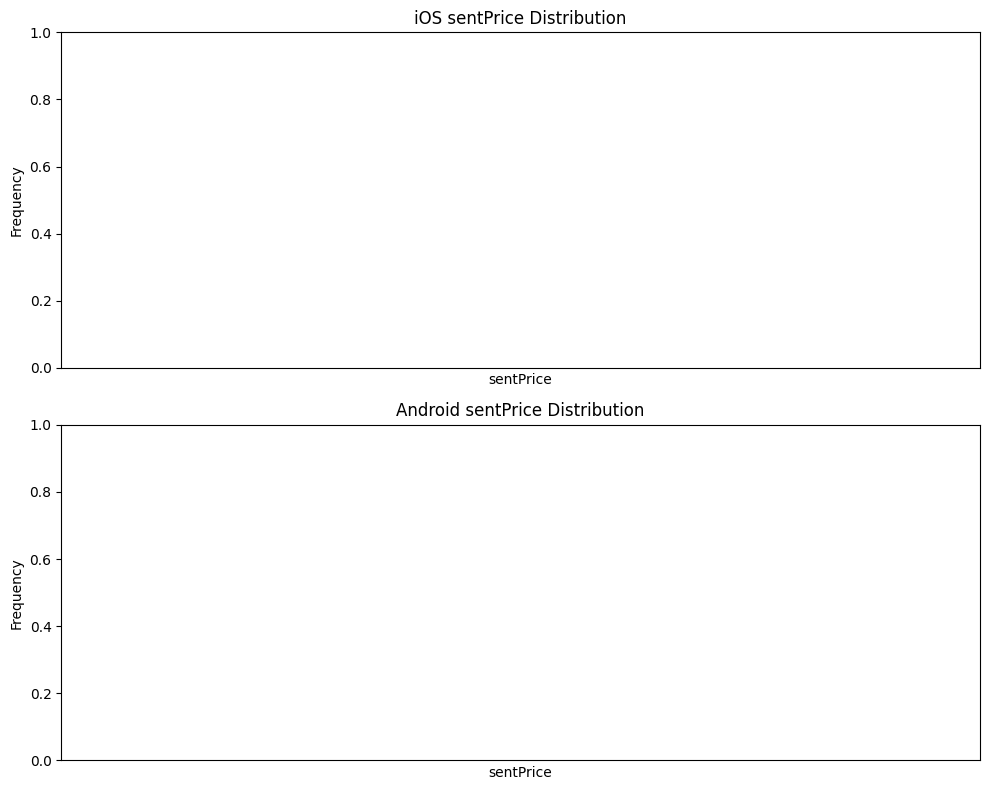

In [7]:
plot_sorted_by_price_distribution(filtered_auction_df, 
                                  first_column='bundleId', second_column='sentPrice', 
                                  first_word="iOS", second_word="Android",
                                  ios_step=10, and_step=10)

# plot_sorted_by_price_distribution(filtered_auction_df, 'brandName', 'sentPrice', "Samsung", "Apple")

In [8]:
# print(filtered_auction_df['bundleId'].value_counts())
# print()
# print(filtered_auction_df['brandName'].value_counts())
# print()
# print(filtered_auction_df['unitDisplayType'].value_counts())
# print()
# print(filtered_auction_df['countryCode'].value_counts())
# print()
# print(filtered_auction_df['osAndVersion'].value_counts())

In [9]:
# Split the auction data into training and testing sets (more for control and evaluetion)
auction_train, auction_test = train_test_split(filtered_auction_df, test_size=0.2, random_state=42, shuffle=True, 
                                               stratify=filtered_auction_df['sentPrice'])  # 20% of data for testing

In [10]:
# Calculate the overall average sentPrice
overall_avg_sent_price = auction_train['sentPrice'].mean()
overall_mesian_sent_price = auction_train['sentPrice'].median()
print(f"Overall mean sent price: {overall_avg_sent_price}")
print(f"Overall median sent price: {overall_mesian_sent_price}")
# Calculate average sentPrice for each combination of attributes
avg_price_by_combination = auction_train.groupby(['unitDisplayType', 'brandName', 'bundleId', 'countryCode', 'osAndVersion'])['sentPrice'].mean()
print(auction_train.groupby(['bundleId'])['sentPrice'].mean().sort_values(ascending=False))

Overall mean sent price: 0.4547386258272852
Overall median sent price: 0.07
bundleId
1569586264                     4.193750
1436213906                     1.639357
1542256628                     0.717500
com.tilegarden.match3          0.702906
1502447854                     0.656249
se.ace.fishinc                 0.633462
com.loop.match3d               0.495345
1586795332                     0.450142
1529614832                     0.422967
com.volt.dresstoimpress        0.399116
1579489488                     0.372333
1523081624                     0.359385
1582745578                     0.328649
com.YayySAL.DodgeAgent         0.313705
dovi.coalmining.inc            0.304520
com.kamilbilge.ropesavior3d    0.278368
com.tintash.nailsalon          0.159994
com.AppIdeas.LevelUpRunner     0.132122
Name: sentPrice, dtype: float64


In [11]:
# Create a mapping from bundleId to embedding for faster lookup
bundle_id_to_embedding = {row['bundleId']: json.loads(row['embedding']) for index, row in app_vectors_df.iterrows()}
# Dictionary to hold the similarity results for each app
app_similarity = {}

# Iterate through each unique app in the auction data
for bundle_id in filtered_auction_df['bundleId'].unique():
    # Find the embedding for the current app
    if bundle_id in bundle_id_to_embedding:
        vec = bundle_id_to_embedding[bundle_id]

        # Prepare and execute the SQL query to find similar apps based on cosine similarity
        sql_query = f'''
        SELECT
            "bundleId"
        FROM app_vectors
        ORDER BY embedding<=>'{json.dumps(vec)}'
        '''
        with engine.connect() as db_con:
            similar_apps_df = pd.read_sql(sql_query, con=db_con)

        # Exclude the current app from its list of similar apps
        similar_apps_list = similar_apps_df['bundleId'].tolist()
        if bundle_id in similar_apps_list:
            similar_apps_list.remove(bundle_id)
        
        # app_similarity[bundle_id] = similar_apps_list
        app_similarity[bundle_id] = {'cosine': similar_apps_list}
    else:
        app_similarity[bundle_id] = []

In [12]:
# Calculate the inverse covariance matrix from all vectors
all_vectors = np.array(list(bundle_id_to_embedding.values()))
covariance_matrix = np.cov(all_vectors, rowvar=False)
inverse_covariance_matrix = inv(covariance_matrix)

# Adding Mahalanobis similar apps to the dictionary
for bundle_id in filtered_auction_df['bundleId'].unique():
    if bundle_id in bundle_id_to_embedding:
        similar_apps_mahalanobis = find_similar_apps_mahalanobis(bundle_id)
        app_similarity[bundle_id]['mahalanobis'] = similar_apps_mahalanobis

In [13]:
# Apply predictions across the test set
auction_test['predicted_price_naive'] = auction_test.apply(apply_naive_prediction, axis=1)

In [14]:
predicted_prices_cosine = []
predicted_prices_mahalanobis = [] 

for index, row in auction_test.iterrows():
    
    similar_apps_cosine = find_similar_apps_cosine(row['bundleId'], top_n=3)
    predicted_prices_cosine.append(calculate_average_price(similar_apps_cosine, auction_train))
    
    similar_apps_mahalanobis = find_similar_apps_mahalanobis(row['bundleId'], top_n=5)
    predicted_prices_mahalanobis.append(calculate_average_price(similar_apps_mahalanobis, auction_train))

auction_test['predicted_price_cosine'] = predicted_prices_cosine
auction_test['predicted_price_mahalanobis'] = predicted_prices_mahalanobis 

In [15]:
# Calculate errors across all test predictions
mse_naive = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_naive'])
mse_cosine = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_cosine'].fillna(0))  # Fill NA if there's no prediction
mse_mahalanobis = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_mahalanobis'].fillna(0))  # Fill NA if there's no prediction

# Print out overall MSE results for comparison
print(f"Overall MSE (Naive): {mse_naive}")
print(f"Overall MSE (Cosine): {mse_cosine}")
print(f"Overall MSE (mahalanobis): {mse_mahalanobis}")

Overall MSE (Naive): 0.8952878970877222
Overall MSE (Cosine): 1.3371807088091465
Overall MSE (mahalanobis): 1.3473150796781284


In [ ]:
# Generate a new auction row with random values from each column
new_auction = {
    'sentPrice': float(),  # Placeholder for the predicted price
    'unitDisplayType': np.random.choice(auction_test['unitDisplayType']),
    'brandName': np.random.choice(auction_test['brandName']),
    'bundleId': np.random.choice(auction_test['bundleId']),
    'countryCode': np.random.choice(auction_test['countryCode']),
    'deviceId': np.random.choice(auction_test['deviceId']),
    'osAndVersion': np.random.choice(auction_test['osAndVersion'])
}
new_auction['sentPrice'] = float(auction_test[auction_test['deviceId'] == new_auction['deviceId']]['sentPrice'])
new_auction

In [16]:
predicted_prices_cosine = []
predicted_prices_mahalanobis = [] 
for index, row in auction_test.iterrows():
    similar_apps_cosine = find_similar_apps_cosine(row['bundleId'], top_n=3)
    predicted_prices_cosine.append(calculate_average_price(similar_apps_cosine, auction_train))
    
    similar_apps_mahalanobis = find_similar_apps_mahalanobis(row['bundleId'], top_n=3)
    predicted_prices_mahalanobis.append(calculate_average_price(similar_apps_mahalanobis, auction_train))

auction_test['predicted_price_cosine'] = predicted_prices_cosine
auction_test['predicted_price_mahalanobis'] = predicted_prices_mahalanobis 
auction_test['predicted_price_naive'] = auction_test.apply(apply_naive_prediction, axis=1)

# Calculate errors across all test predictions
mse_naive = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_naive'])
mse_cosine = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_cosine'].fillna(0))  # Fill NA if there's no prediction
mse_mahalanobis = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_mahalanobis'].fillna(0))  # Fill NA if there's no prediction

# Print out overall MSE results for comparison
print(f"Overall MSE (Naive): {mse_naive}")
print(f"Overall MSE (Cosine): {mse_cosine}")
print(f"Overall MSE (mahalanobis): {mse_mahalanobis}")

Overall MSE (Naive): 0.8952878970877222
Overall MSE (Cosine): 1.3371807088091465
Overall MSE (mahalanobis): 1.369829196817757


In [ ]:
plt.figure(figsize=(21, 7))  # Extend figure size to accommodate three subplots

# Plot for Naive Predictions
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.scatterplot(x=auction_test['sentPrice'], y=auction_test['predicted_price_naive'])
plt.title('Actual vs. Naive Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Naive Predicted Prices')

# Plot for Cosine Similarity Predictions
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.scatterplot(x=auction_test['sentPrice'], y=auction_test['predicted_price_cosine'])
plt.title('Actual vs. Cosine Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Cosine Predicted Prices')

# Plot for Mahalanobis Distance Predictions
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.scatterplot(x=auction_test['sentPrice'], y=auction_test['predicted_price_mahalanobis'].fillna(0))  # Filling NA if there's no prediction
plt.title('Actual vs. Mahalanobis Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Mahalanobis Predicted Prices')

plt.tight_layout()
plt.show()

In [ ]:
## func section 
def add_embeddings(df, embedding_dict):
    
    default_embedding = [0] * len(next(iter(embedding_dict.values())))
    df['embedding'] = df['bundleId'].apply(lambda x: embedding_dict.get(x, default_embedding))
    
    embeddings = df['embedding'].tolist()
    
    new_columns = [f'emb_{i}' for i in range(len(default_embedding))]
    df[new_columns] = pd.DataFrame(embeddings, index=df.index)
    
    return df, new_columns
    
def train_linear_regression(X_train, y_train, X_test, y_test):
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    predictions = lin_reg.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE for Linear Regression: {mse}")
    
    return lin_reg

def apply_clustering(X_train_scaled, X_test_scaled, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters_train = kmeans.fit_predict(X_train_scaled)
    clusters_test = kmeans.predict(X_test_scaled)
    return clusters_train, clusters_test
    
def determine_optimal_clusters(X_scaled, max_clusters=10):

    silhouette_scores = []
    range_n_clusters = range(2, max_clusters + 1)  # At least 2 clusters are needed to define silhouette score

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    # Find the number of clusters that gives the maximum silhouette score
    optimal_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]

    # Plotting to find the "elbow"
    plt.figure()
    plt.plot(range_n_clusters, silhouette_scores, 'bo-')
    plt.title('Finding the Optimal Number of Clusters')
    plt.xlabel('Clusters')
    plt.ylabel('Inertia')
    plt.show()
    
    return optimal_clusters

def train_logistic_regression(X_train, y_train, X_test, y_test):
    parameters = {'C': [0.01, 0.05, 0.1, 0.5], 'max_iter': [100]}
    log_reg = LogisticRegression()
    clf = GridSearchCV(log_reg, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    best_model = clf.best_estimator_
    predictions = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print(f"Best parameters: {clf.best_params_}\n")
    print(f"Accuracy for Logistic Regression: {accuracy}\n")
    print(classification_report(y_test, predictions))
    
    return best_model

In [ ]:
# Apply this function to both datasets and capture the new column names for embeddings
auction_train, embedding_features = add_embeddings(auction_train.copy(), bundle_id_to_embedding)
auction_test, _ = add_embeddings(auction_test.copy(), bundle_id_to_embedding)

# Apply Machine Learning Models
X_train_emb = auction_train[embedding_features]
y_train = auction_train['sentPrice']
X_test_emb = auction_test[embedding_features]
y_test = auction_test['sentPrice']

# Scaling - important for regression and clustering with embedding features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled = scaler.transform(X_test_emb)

In [ ]:
# Linear Regression with Embeddings
lin_reg_emb = train_linear_regression(X_train_scaled, y_train, X_test_scaled, y_test)
X_train_all = pd.get_dummies(auction_train[embedding_features], drop_first=True)

# Print the importance of features from the all-features model
print("Top 3 most important characteristics for predicting the price:")
importance = pd.Series(lin_reg_emb.coef_, index=X_train_emb.columns).sort_values(key=abs, ascending=False)
print(importance.head(12))

In [ ]:
# Apply Machine Learning Models
n = 10
X_train_emb_agn = auction_train[importance.index[:n].tolist()]
y_train = auction_train['sentPrice']
X_test_emb_agn = auction_test[importance.index[:n].tolist()]
y_test = auction_test['sentPrice']

# Scaling - important for regression and clustering with embedding features
scaler_agn = StandardScaler()
X_train_scaled_agn = scaler_agn.fit_transform(X_train_emb_agn)
X_test_scaled_agn = scaler_agn.transform(X_test_emb_agn)

# Linear Regression with Embeddings
lin_reg_emb_agn = train_linear_regression(X_train_scaled_agn, y_train, X_test_scaled_agn, y_test)

In [ ]:
all_features = ['unitDisplayType', 'brandName', 'countryCode', 'osAndVersion', 'bundleId']

# Regression with All Features
X_train_all = pd.get_dummies(auction_train[all_features], drop_first=True)
X_test_all = pd.get_dummies(auction_test[all_features], drop_first=True)
X_test_all = X_test_all.reindex(columns = X_train_all.columns, fill_value=0)  # Align columns

lin_reg_all = train_linear_regression(X_train_all, y_train, X_test_all, y_test)

# Print the importance of features from the all-features model
print("Top 3 most important characteristics for predicting the price:")
importance = pd.Series(lin_reg_all.coef_, index=X_train_all.columns).sort_values(key=abs, ascending=False)
print(importance.head(10))

In [ ]:
# Apply Machine Learning Models
n = 12
X_train_emb_agn = X_train_all[importance.index[:n].tolist()]
y_train = auction_train['sentPrice']
X_test_emb_agn = X_test_all[importance.index[:n].tolist()]
y_test = auction_test['sentPrice']

# Scaling - important for regression and clustering with embedding features
scaler_agn = StandardScaler()
X_train_scaled_agn = scaler_agn.fit_transform(X_train_emb_agn)
X_test_scaled_agn = scaler_agn.transform(X_test_emb_agn)

# Linear Regression with Embeddings
lin_reg_emb_agn = train_linear_regression(X_train_scaled_agn, y_train, X_test_scaled_agn, y_test)

In [ ]:
optimal_clusters = determine_optimal_clusters(X_train_scaled, max_clusters=10)
auction_train['cluster'], auction_test['cluster'] = apply_clustering(X_train_scaled, X_test_scaled, optimal_clusters)

In [ ]:
auction_train.groupby('cluster')['sentPrice'].median().sort_values(ascending=False)
auction_train.groupby('cluster')['sentPrice'].mean().sort_values(ascending=False)

In [ ]:
for cluster_index in auction_train['cluster'].unique():
    print(auction_train[auction_train['cluster'] == i].groupby('bundleId')['sentPrice'].mean().sort_values(ascending=False))

In [ ]:
auction_train['price_category'] = pd.qcut(auction_train['sentPrice'], 5, labels=['low', 'medium-', 'medium', 'medium+','high'])
auction_test['price_category'] = pd.qcut(auction_test['sentPrice'], 5, labels=['low', 'medium-', 'medium', 'medium+', 'high'])

# Prepare data for logistic regression
X_train_cat = auction_train[embedding_features]  # Assuming embeddings are numerical and correctly scaled
y_train_cat = auction_train['price_category']
X_test_cat = auction_test[embedding_features]
y_test_cat = auction_test['price_category']

# Make sure the embeddings are scaled
scaler_cat = StandardScaler()
X_train_cat_scaled = scaler_cat.fit_transform(X_train_cat)
X_test_cat_scaled = scaler_cat.transform(X_test_cat)

# Logistic Regression with Embeddings
log_reg_model_emb = train_logistic_regression(X_train_scaled, y_train_cat, X_test_scaled, y_test_cat)

In [ ]:
# Train Logistic Regression
log_reg_model_cat = train_logistic_regression(X_train_cat_scaled, y_train_cat, X_test_cat_scaled, y_test_cat)

In [ ]:
# Logistic Regression with Embeddings
log_reg_model_emb = train_logistic_regression(X_train_scaled, y_train_cat, X_test_scaled, y_test_cat)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the dataset for regression analysis
X_train = auction_train[['unitDisplayType', 'brandName', 'countryCode']]  # Add more features as necessary
X_train = pd.get_dummies(X_train, drop_first=True)  # One-hot encode categorical features
y_train = auction_train['sentPrice']

# Similarly, prepare the test set
X_test = auction_test[['unitDisplayType', 'brandName', 'countryCode']]  # Ensure this matches the training set features
X_test = pd.get_dummies(X_test, drop_first=True)
y_test = auction_test['sentPrice']

# Handle any mismatch in columns after one-hot encoding between train and test sets
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

# Perform Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions_lin = lin_reg.predict(X_test)

# Measure and print out the performance
mse_lin = mean_squared_error(y_test, predictions_lin)
print(f"MSE for Linear Regression: {mse_lin}")

# Importance of features
feature_importance = pd.Series(lin_reg.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
print("Top 3 most important features for predicting the price:")
feature_importance.head(3)